In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn import datasets

boston = datasets.load_boston()
X = boston['data']
y = boston['target']

In [13]:
def standard_scaler(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    return (X-means)/stds

# function used in the Lasso regression gradient
def sign(x, first_element_zero = False):
    signs = (-1)**(x < 0)
    
    # wheter to prevent Lasso from penalizing the magnitude of the intercept
    if first_element_zero:
        signs[0] = 0
    return signs

The following class allows Ridge and Lasso regression by finding, respectivelly, the following $\hat{\beta}$:

* $\hat{\beta} = (X^TX + \lambda I')^{-1}X^Ty$ for Ridge regression, and;
* $\frac{\delta L(\hat{\beta})}{\delta\hat{\beta}} = -X^T(y - X\hat{\beta}) + \lambda I'sign(\hat{\beta})$ for Lasso regression.

In [14]:
class RegularizedRegression:
    
    def _record_info(self, X, y, lam, intercept, standardize):
        
        # standardize
        if standardize == True:
            X = standard_scaler(X)
        
        # add intercept
        if intercept == False:
            ones = np.ones(len(X)).reshape(len(X), 1) # column of ones
            X = np.concatenate((ones, X), axis=1) # concatenate
            
        # record values
        self.X = np.array(X)
        self.y = np.array(y)
        self.N, self.D = self.X.shape
        self.lam = lam
        
    def fit_ridge(self, X, y, lam=0, intercept=False, standardize=True):
        
        # record data and dimensions
        self._record_info(X, y, lam, intercept, standardize)
        
        # estimate parameters
        XtX = np.dot(self.X.T, self.X)
        I_prime = np.eye(self.D)
        I_prime[0, 0] = 0
        XtX_plus_inverse = np.linalg.inv(XtX + self.lam*I_prime)
        Xty = np.dot(self.X.T, self.y)
        self.beta_hats = np.dot(XtX_plus_inverse, Xty)
        
        self.y_hat = np.dot(self.X, self.beta_hats)
        
        
    def fit_lasso(self, X, y, lam=0, n_iters=2000, lr=0.0001, intercept=False, standardize=True):
        
        self._record_info(X, y, lam, intercept, standardize)
        
        # perform gradient descent
        beta_hats = np.random.randn(self.D)
        I_prime = np.eye(self.D)
        I_prime[0,0] = 0 
        for i in tqdm(range(n_iters)):
            dL_dbeta = -np.dot(self.X.T, (self.y - np.dot(self.X, beta_hats))) + self.lam*sign(beta_hats, True)
            beta_hats = beta_hats - lr*dL_dbeta
        
        self.beta_hats = beta_hats
        
        self.y_hat = np.dot(self.X, self.beta_hats)

In [15]:
# set lambda
lam = 10

# fit ridge 
ridge_model = RegularizedRegression()
ridge_model.fit_ridge(X, y, lam)

# fit lasso
lasso_model = RegularizedRegression()
lasso_model.fit_lasso(X, y, lam)

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 39831.95it/s]


100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 44205.71it/s]


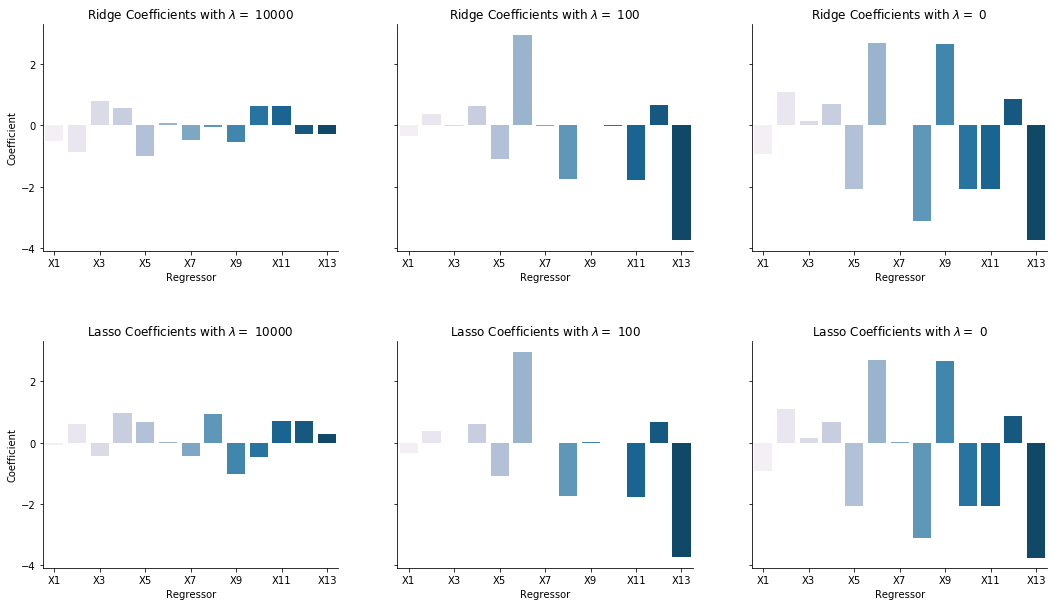

In [17]:
Xs = ['X'+str(i + 1) for i in range(X.shape[1])]
lams = [10**4, 10**2, 0]


fig, ax = plt.subplots(nrows = 2, ncols = len(lams), figsize = (6*len(lams), 10), sharey = True)
for i, lam in enumerate(lams):
    
    ridge_model = RegularizedRegression()
    ridge_model.fit_lasso(X, y, lam) 
    ridge_betas = ridge_model.beta_hats[1:]
    sns.barplot(Xs, ridge_betas, ax = ax[0, i], palette = 'PuBu')
    ax[0, i].set(xlabel = 'Regressor', title = fr'Ridge Coefficients with $\lambda = $ {lam}')
    ax[0, i].set(xticks = np.arange(0, len(Xs), 2), xticklabels = Xs[::2])
    
    lasso_model = RegularizedRegression()
    lasso_model.fit_lasso(X, y, lam) 
    lasso_betas = lasso_model.beta_hats[1:]
    sns.barplot(Xs, lasso_betas, ax = ax[1, i], palette = 'PuBu')
    ax[1, i].set(xlabel = 'Regressor', title = fr'Lasso Coefficients with $\lambda = $ {lam}')
    ax[1, i].set(xticks = np.arange(0, len(Xs), 2), xticklabels = Xs[::2])

ax[0,0].set(ylabel = 'Coefficient')
ax[1,0].set(ylabel = 'Coefficient')
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
sns.despine()
sns.set_context('talk');